## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different characteristic of the data impact our ability to decode position.
In particular:

A - Try to use different fraction of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

In [297]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from ipywidgets import interact
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [298]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [299]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [300]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [301]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [302]:
#def plot_unit(i):
#    plt.plot(t, x)
#    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
#interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

In [303]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape


# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   



100%|█████████████████████████████████████████████████████████████████████████████| 4524/4524 [00:22<00:00, 202.53it/s]


Text(0, 0.5, 'Median error')

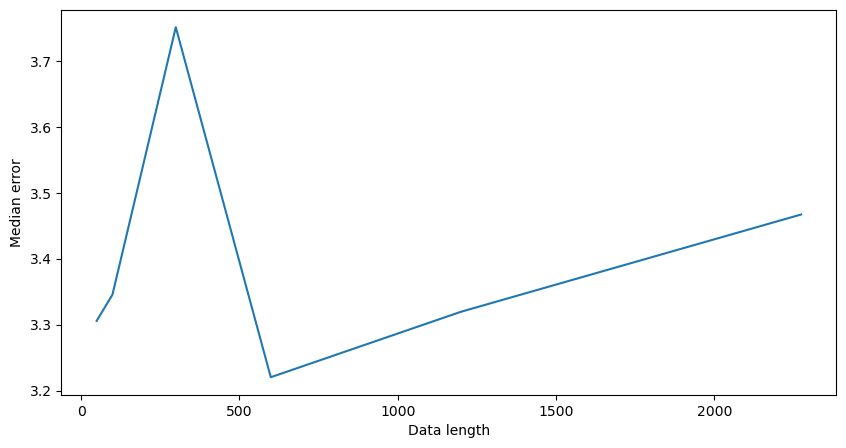

In [304]:

start_array = [0,50,150,450,1050,2250]
stop_array = [49,149,449,1049,2249,len(true_x)]
mse_array = np.empty(len(start_array))
data_length = np.empty(len(start_array))

for i in range(len(start_array)):
    start = start_array[i]
    stop = stop_array[i]
    mse = np.sqrt((true_x[start:stop]-x_decoded[start:stop])**2)
    length = stop - start

    #print(f'Median error: {np.nanmedian(mse)} cm, data length: {length}')
    
    mse_array[i] = np.nanmedian(mse)
    data_length[i] = length

plt.figure()
plt.plot(data_length, mse_array)
plt.xlabel('Data length')
plt.ylabel('Median error')

B - How many place cells do we need to reliably decode? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)



In [306]:
n_cells_array = [10,20,40,60,100,120]
mse_array = np.empty(len(n_cells_array))
for n in range(len(n_cells_array)):

    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = n_cells_array[n] # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
    
    # GENERATE TRAJECTORY

    n_runs = 10
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])


    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
             x = np.concatenate((x, run1, run2))
    t = np.arange(len(x))/fps
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = 0.1 # the baseline noise firing rate
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    import pickle

    file_name = 'linear_track_data.pickle' # change this name when you save new data

    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    with open('data/'+file_name,'wb') as f:
        pickle.dump(out_data,f)

        
    
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape


    # code decoding
    from scipy.stats import poisson

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    mse = np.sqrt((true_x[start:stop]-x_decoded[start:stop])**2)
    mse_array[n] = np.nanmedian(mse)
    

100%|█████████████████████████████████████████████████████████████████████████████| 4224/4224 [00:22<00:00, 188.69it/s]


Text(0, 0.5, 'median error')

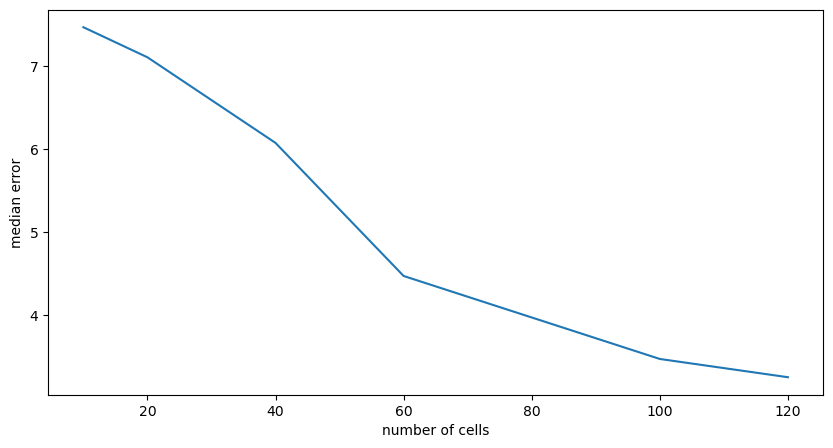

In [307]:
plt.figure()
plt.plot(n_cells_array,mse_array)
plt.xlabel('number of cells')
plt.ylabel('median error')

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [308]:
noise_firing_rate_array = [0.05,0.1,0.2]
mse_array = np.empty(len(noise_firing_rate_array))
for n in range(len(noise_firing_rate_array)):

    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
    
    # GENERATE TRAJECTORY

    n_runs = 10
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])


    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
             x = np.concatenate((x, run1, run2))
    t = np.arange(len(x))/fps
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = noise_firing_rate_array[n] # the baseline noise firing rate
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    import pickle

    file_name = 'linear_track_data.pickle' # change this name when you save new data

    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    with open('data/'+file_name,'wb') as f:
        pickle.dump(out_data,f)
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape


    # code decoding
    from scipy.stats import poisson

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    mse = np.sqrt((true_x[start:stop]-x_decoded[start:stop])**2)
    mse_array[n] = np.nanmedian(mse)
    

100%|█████████████████████████████████████████████████████████████████████████████| 4811/4811 [00:23<00:00, 204.19it/s]


Text(0, 0.5, 'median error')

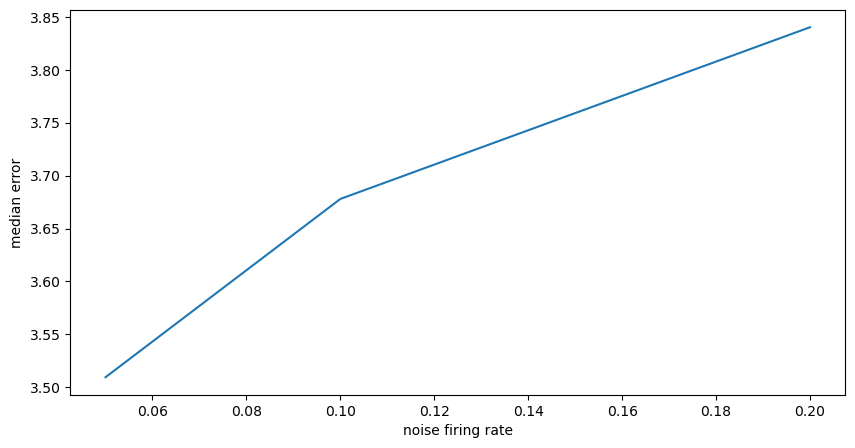

In [309]:
plt.figure()
plt.plot(noise_firing_rate_array,mse_array)
plt.xlabel('noise firing rate')
plt.ylabel('median error')

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?

In [310]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))


# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = noise_firing_rate_array[n] # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape


# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

In [311]:
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   

100%|█████████████████████████████████████████████████████████████████████████████| 4287/4287 [00:25<00:00, 167.36it/s]


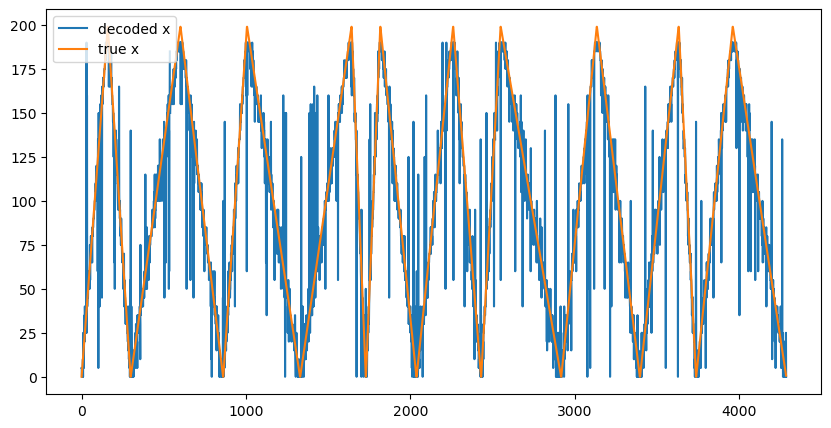

In [312]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

In [313]:
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            #posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))

        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 4287/4287 [00:27<00:00, 156.36it/s]


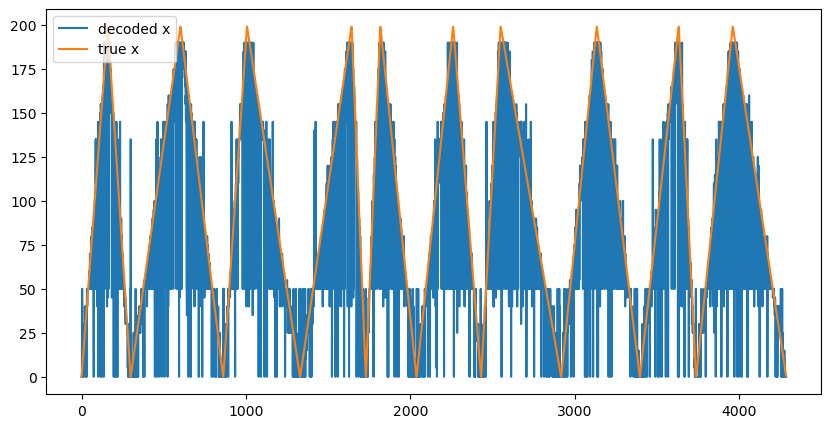

In [314]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

The difference between the two is that the logpmf function provides a narrower decoded x than the log of the pmf function.
The logpmf is descibed by python documentation as the log of the probability mass function. Which should be the same as taking the log of the probability mass function yourself. However, as can be seen this is not entirely true. 

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?




In [315]:
# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1
        
    


Text(0, 0.5, 'cell #')

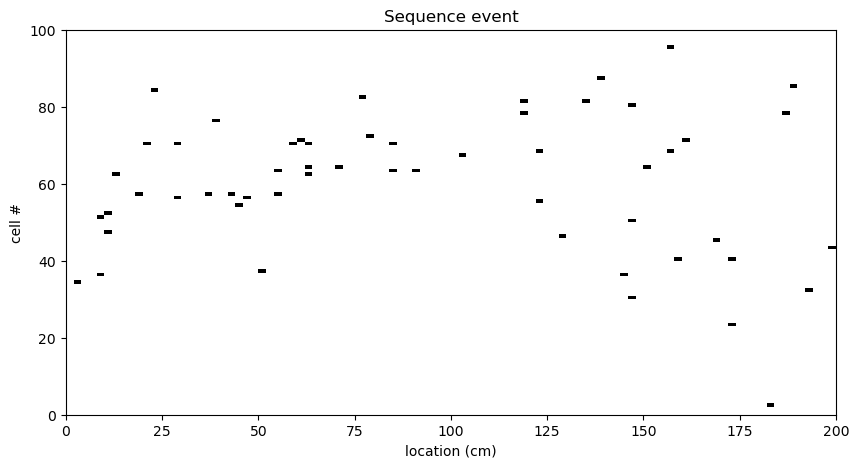

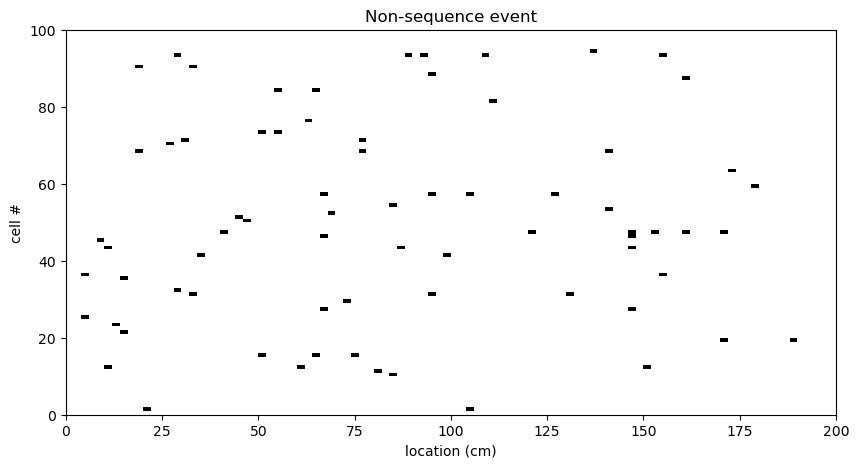

In [316]:
pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)


event = 50
plt.figure(figsize=(10,5))
plt.title('Sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

event = 150
plt.figure(figsize=(10,5))
plt.title('Non-sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

In [317]:

time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [318]:
# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]


<Axes: ylabel='Count'>

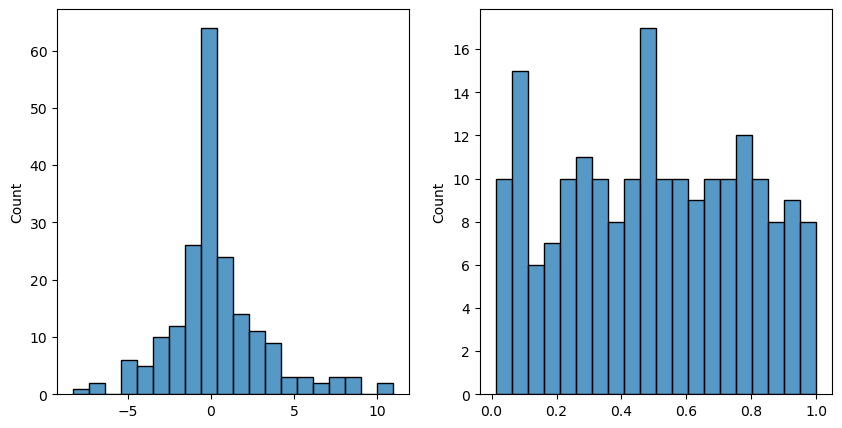

In [319]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes,bins=20)
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues,bins=20)

In [320]:
#pvalues 
positions_sequential = []
positions_nonsequential = []
for i in range(len(reactivation_pvalues)):
    if reactivation_pvalues[i] < 0.05:
        positions_sequential.append(i)
    elif reactivation_pvalues[i] >= 0.05:
        positions_nonsequential.append(i)
        

In [321]:
false_positive = 0
false_negative = 0

for i in range(len(positions_sequential)):
    if positions_sequential[i] > 99:
        false_positive += 1
        
for i in range(len(positions_nonsequential)):
    if positions_nonsequential[i] < 100:
        false_negative += 1

In [322]:
print(f'Number of false positives: {false_positive}')
print(f'Number of false negatives: {false_negative}')

Number of false positives: 4
Number of false negatives: 95


B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.



In [323]:
noise_x_react_array = [1,5,10]
false_positive = np.zeros(len(noise_x_react_array))
false_negative = np.zeros(len(noise_x_react_array))

for noise in range(len(noise_x_react_array)):
# generate data 

    n_events = 200 # number of reactivation events
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_x_react=noise_x_react_array[noise]; # Noise in the reactivation of the sequence
    noise_t_react=5; # Noise in the timing of the spikes 
    noise_firing_rate = 0.1 # the baseline noise firing rate


    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length

        #store reactivation sequence
        reactivation_events[event,:] = x_react


        # Generate spikes according to the location being reactivated in this event

        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1

    pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
    sorted_idxs = np.argsort(pfc_idxs)

    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

    #to do: bayesian decoding
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]


    #pvalues 
    positions_sequential = []
    positions_nonsequential = []
    for i in range(len(reactivation_pvalues)):
        if reactivation_pvalues[i] < 0.05:
            positions_sequential.append(i)
        elif reactivation_pvalues[i] >= 0.05:
            positions_nonsequential.append(i)

    for p in range(len(positions_sequential)):
        if positions_sequential[p] > 99:
            false_positive[noise] += 1

    for n in range(len(positions_nonsequential)):
        if positions_nonsequential[n] < 100:
            false_negative[noise] += 1

C:\Users\Noor\mambaforge\envs\neural_data\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


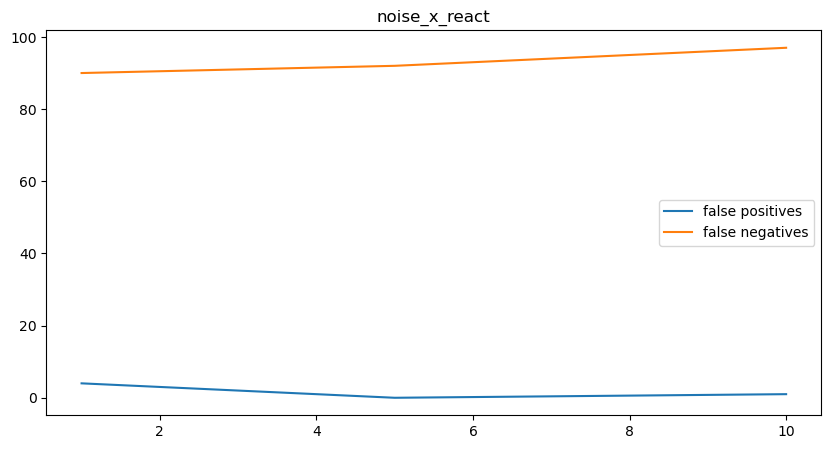

In [324]:
plt.figure()
plt.title('noise_x_react')
plt.plot(noise_x_react_array,false_positive,label='false positives')
plt.plot(noise_x_react_array,false_negative,label='false negatives')
plt.legend()

In [325]:
noise_t_react_array = [1,5,10]
false_positive = np.zeros(len(noise_x_react_array))
false_negative = np.zeros(len(noise_x_react_array))

for noise in range(len(noise_t_react_array)):
# generate data 

    n_events = 200 # number of reactivation events
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_x_react=5; # Noise in the reactivation of the sequence
    noise_t_react=noise_t_react_array[noise]; # Noise in the timing of the spikes 
    noise_firing_rate = 0.1 # the baseline noise firing rate


    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length

        #store reactivation sequence
        reactivation_events[event,:] = x_react


        # Generate spikes according to the location being reactivated in this event

        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1

    pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
    sorted_idxs = np.argsort(pfc_idxs)

    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

    #to do: bayesian decoding
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]


    #pvalues 
    positions_sequential = []
    positions_nonsequential = []
    for i in range(len(reactivation_pvalues)):
        if reactivation_pvalues[i] < 0.05:
            positions_sequential.append(i)
        elif reactivation_pvalues[i] >= 0.05:
            positions_nonsequential.append(i)

    for p in range(len(positions_sequential)):
        if positions_sequential[p] > 99:
            false_positive[noise] += 1

    for n in range(len(positions_nonsequential)):
        if positions_nonsequential[n] < 100:
            false_negative[noise] += 1

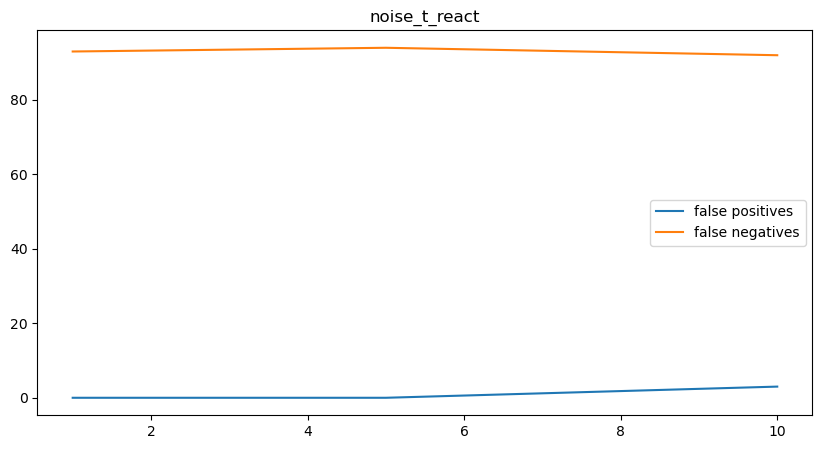

In [326]:
plt.figure()
plt.title('noise_t_react')
plt.plot(noise_x_react_array,false_positive,label='false positives')
plt.plot(noise_x_react_array,false_negative,label='false negatives')
plt.legend()

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?

It can detect sequences that have a computable probability distribution. 